## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install rasterio
import xarray as xr
import pandas as pd
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.3 MB/s eta 0:00:00


## Init

Your data repository should look like **this** after downloading all input data (non-exhaustive list of files):

![image-2.png](attachment:image-2.png)

In [ ]:
main_data_folder = "/content/drive/MyDrive/data/"

# Administration geometries from GADM

In [7]:
gadm_filepath = main_data_folder + "gadm_410.gpkg"

NameError: name 'main_data_folder' is not defined

## Parametrize

In [5]:
country_code = "FRA"
cityname = "Paris"

In [6]:
gadm_gdf = gpd.read_file(gadm_filepath)

print(f"Number of rows in GADM: {len(gadm_gdf)}")
gadm_gdf.head()

NameError: name 'gpd' is not defined

In [ ]:
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == country_code) & (gadm_gdf.NAME_2 == cityname)]

print(f"Number of rows in GADM after filtering: {len(filtered_gadm_gdf)}")
filtered_gadm_gdf.head()

Number of rows in GADM after filtering: 20


,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
76389,76390,FRA,France,,FRA.8_1,Île-de-France,,,,FR.IF,...,Commune,,France,,,,France,Europe,,"MULTIPOLYGON (((2.39907 48.84809, 2.36902 48.8..."
76390,76391,FRA,France,,FRA.8_1,Île-de-France,,,,FR.IF,...,Commune,,France,,,,France,Europe,,"MULTIPOLYGON (((2.36902 48.85323, 2.39907 48.8..."
76391,76392,FRA,France,,FRA.8_1,Île-de-France,,,,FR.IF,...,Commune,,France,,,,France,Europe,,"MULTIPOLYGON (((2.37701 48.87192, 2.36386 48.8..."
76392,76393,FRA,France,,FRA.8_1,Île-de-France,,,,FR.IF,...,Commune,,France,,,,France,Europe,,"MULTIPOLYGON (((2.36596 48.84491, 2.39007 48.8..."
76393,76394,FRA,France,,FRA.8_1,Île-de-France,,,,FR.IF,...,Commune,,France,,,,France,Europe,,"MULTIPOLYGON (((2.31415 48.82229, 2.30132 48.8..."


In [ ]:
one_city_gdf = filtered_gadm_gdf.dissolve()

one_city_gdf.head()

,geometry,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,...,TYPE_5,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT
0,"POLYGON ((2.27193 48.82888, 2.26762 48.8342, 2...",76390,FRA,France,,FRA.8_1,Île-de-France,,,,...,Chef-lieu canton,Commune,,France,,,,France,Europe,


<Axes: >

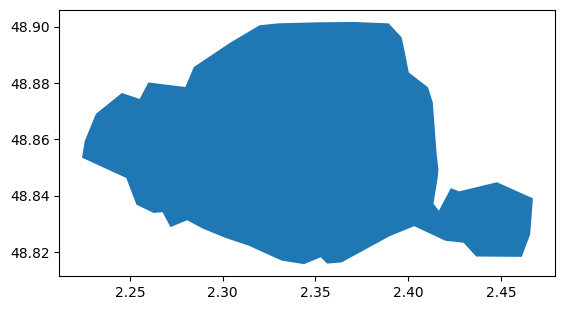

In [ ]:
one_city_gdf.plot()

# ERA5 Meteorological data (frequency = daily)

In [ ]:
era5_data_folder = main_data_folder + "derived-era5-single-levels-daily-statistics/"

variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}

## Parametrize

In [ ]:
variable = "2m_temperature"
year = 2017

In [ ]:
statistic = variable2statistic[variable]
datavar = variable2datavar[variable]

filepath = f"{era5_data_folder}{year}_{variable}_{statistic}.nc"

## Manipulate and vizualize

Please open the [xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/index.html) to see how to manipulate the data (especially in the "Core operations" chapter).

Here are a few examples of operations:

In [ ]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset> Size: 55MB
Dimensions:     (valid_time: 365, latitude: 141, longitude: 265)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2017-01-01 ... 2017-12-31
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 2kB -25.0 -24.75 -24.5 ... 40.5 40.75 41.0
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 55MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-24T03:20 GRIB to CDM+CF via cfgrib-0.9.1...

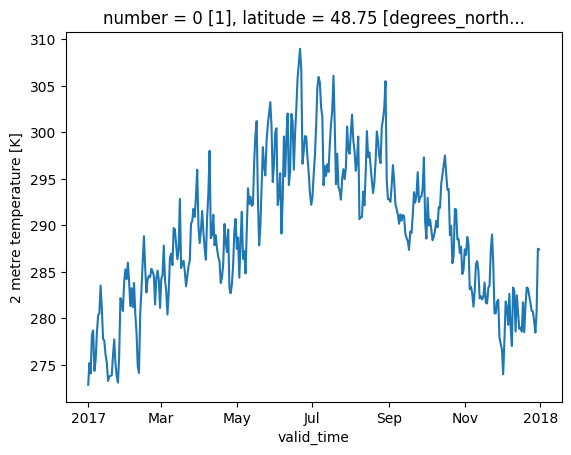

In [ ]:
lat, lon = 48.8566, 2.3522

ds[datavar].sel(latitude=lat, longitude=lon, method="nearest").plot()

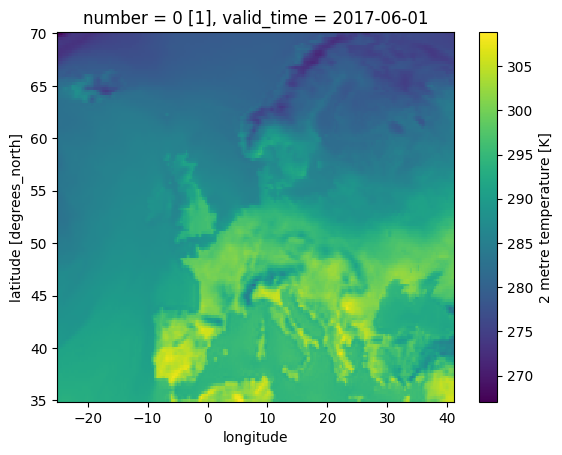

In [ ]:
day = pd.to_datetime(f"{year}-06-01")

ds[datavar].sel(valid_time=day).plot()

# Normalized Difference Vegetation Index from Sentinel-3 (frequency = every 10 days)

In [ ]:
ndvi_data_folder = main_data_folder + "sentinel3-olci-ndvi/"

## Parametrize

In [ ]:
day_YYYYMMDD = "20200701"

In [ ]:
filepath  = f"{ndvi_data_folder}SENTINEL3_OLCI_Europe_NDVI_{day_YYYYMMDD}.tif"

## Manipulate and vizualize

In [ ]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in 0-255 scale.
    # we convert it to -1 to 1 scale and float and replace nodata with np.nan
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 255 * 2 - 1
    return ndvi_img

In [ ]:
with rasterio.open(filepath) as src:
    city_geometry = [one_city_gdf.geometry.iloc[0]]
    out_image, out_transform = mask(src, city_geometry, crop=True)
    out_meta = src.meta

    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

NameError: name 'rasterio' is not defined

In [ ]:
plt.figure()
plt.imshow(real_out_image[0], cmap='Greens', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"NDVI over {cityname} on {day_YYYYMMDD}")
plt.axis('off')
plt.show()

In [ ]:
mean_ndvi = np.nanmean(real_out_image[0])
print(f"Mean NDVI over {cityname} on {day_YYYYMMDD}: {mean_ndvi:.3f}")

In [ ]:
#ajouts # Charger toutes les années disponibles pour une variable
filepaths = glob(f"{era5_data_folder}*_{variable}_{statistic}.nc")
ds = xr.open_mfdataset(filepaths, combine="by_coords")
ds
# Résumé rapide
print(ds)

print("\nDimensions :")
print(ds.dims)

print("\nCoordonnées temporelles :")
print("De", pd.to_datetime(ds.valid_time.min().item()),
      "à", pd.to_datetime(ds.valid_time.max().item()))

print("\nAttributs de la variable principale :")
print(ds[datavar].attrs)
# Carte moyenne sur toute la période
ds[datavar].mean(dim="valid_time").plot()
plt.title(f"{variable} - moyenne sur toute la période")
plt.show()
